## Histopathologic Cancer Detection Project

### Problem Overview
The overall objective of this project is to identify metastatic cancer in small images. The images have been collected by taking smaller patches from larger digital pathology scans. The data is similar to the PatchCamelyon (PCam) benchmark dataset with minimal processing to remove duplicate images.

### Data Description
The actual data is quite direct with an `id` (referencing the specific image) and a `label` (which classifies the patch as cancerous) for the image and an image of size 96x96 pixels. There is further specification that there is a patch (the center 32x32 pixels) which we are classifying whether or not it is cancerous. This patch will contain at least one pixel of tumor tissue for positive instances and the tumor tissue in the outer region of the patch does not influence the label. The total size of the train dataset is 220025.
- Image: 96x96 pixels stored in `.tif` format
- `id`: references image name
- `label`: whether the patch within the image is cancerous (1 = cancerous, 0 = not cancerous)

In [1]:
!ls -1 train | wc -l

220025


In [2]:
!ls -1 test | wc -l

57458


In [3]:
import pandas as pd

df = pd.read_csv("train_labels.csv")
df['id'] = df['id'].apply(lambda x: f"{x}.tif")
df['label'] = df['label'].astype(str)
df

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6.tif,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576.tif,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75.tif,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2.tif,0


In [4]:
from sklearn.model_selection import train_test_split

# Create Validation set
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

## Exploratory Data Analysis (EDA)

Determine the distribution of cancerous and non-cancerous samples. Fairly balanced distribution of classes. Given the quantity of data there is no shortage of positive or negative instances within the dataset. 

To get a better understanding of the images being classified, I randomly selected 3 positively and negatively classified images. Generally, the cancerous images are more densely packed with cells compared to non-cancerous images, but this assumption doesn't always hold. I would certainly not be able to effectively classify these images which does suggest classification would benefit from a model.

<Axes: xlabel='label', ylabel='count'>

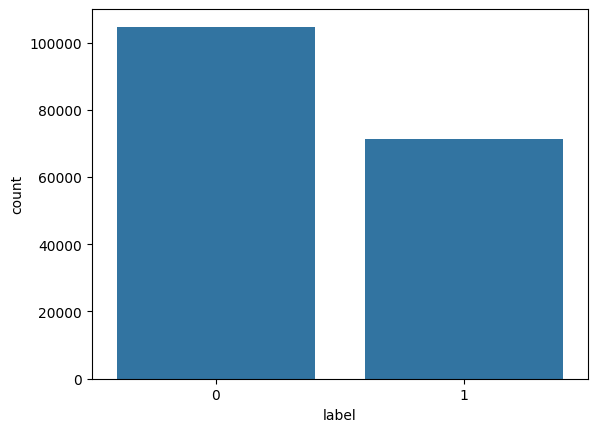

In [5]:
import seaborn as sns

sns.countplot(x='label', data=train_df)

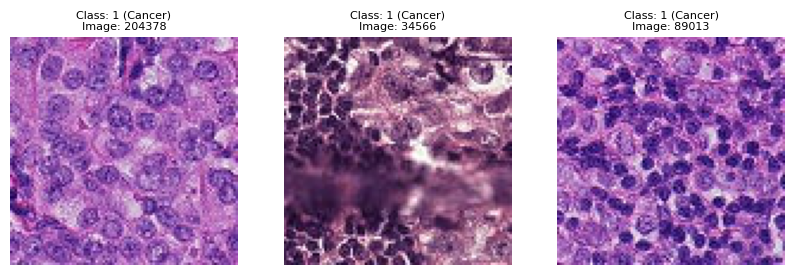

In [6]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 8))

idcs = np.random.choice(train_df[train_df['label'] == '1'].index, 3)
positive_ids = train_df[train_df['label'] == '1'].loc[idcs]['id']

for i, positive_id in enumerate(positive_ids):
    positive_img = plt.imread(f"train/{positive_id}")
    axes[i].imshow(positive_img)
    axes[i].set_title(f"Class: 1 (Cancer)\nImage: {idcs[i]}", fontsize=8)
    axes[i].axis('off')

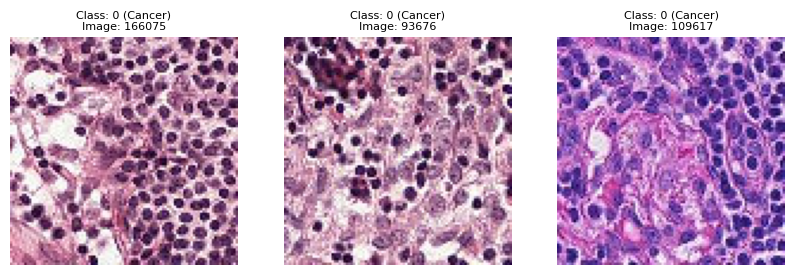

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 8))

idcs = np.random.choice(train_df[train_df['label'] == '0'].index, 3)
negative_ids = train_df[train_df['label'] == '0'].loc[idcs]['id']

for i, negative_id in enumerate(negative_ids):
    negative_img = plt.imread(f"train/{negative_id}")
    axes[i].imshow(negative_img)
    axes[i].set_title(f"Class: 0 (Cancer)\nImage: {idcs[i]}", fontsize=8)
    axes[i].axis('off')

## DModel Architecture
### Initial baseline architecture:
- Conv2D (relu)
- MaxPooling2D
- Conv2D (relu)
- MaxPooling2D
- Conv2D (relu)
- MaxPooling2D
- Dense Fully Connected (relu)
- Dense to output (sigmoid)

### Expected Architecture Improvements
Since the image is relatively small I'm thinking of running 2 convolutional layers into a pooling layer as a singular component. I'd expect 3-to-4 components would do a relatively good job of classifying. I'll use Relu activation functions with the final output being fed into a sigmoid function as this is a binary classification problem. 

I would like factor in the patch element of this specific problem space. Either incorperating padding or potentially honing in on the center 32x32 pixel group with some deep convolution I believe will help reveal more insight into that portion of the image, thus leading to better classification.

For the SGD I will move in favor of Adam and for the loss I will use binary cross entropy as this is a binary classification problem.

#### Hyperparameters
- Activation function: Relu
- Output activation function: Sigmoid
- Optimizer: Adam
- Learning Rate: 0.0001
- Loss Function: Binary Crossentropy

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 96
BATCH_SIZE = 50

train_datagen = ImageDataGenerator(rescale=1./255.)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='train',
    x_col='id',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    steps_per_epoch=100,
    class_mode='binary'
)

valid_datagen = ImageDataGenerator(rescale=1./255.)
validation_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory='train',
    x_col='id',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    steps_per_epoch=100,
    class_mode='binary',
    shuffle=False
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential([
    # Input Layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    MaxPooling2D((2, 2)),
    
    # Second Convolutional Layer
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Second Convolutional Layer
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Flatten and Dense Layers
    Flatten(),
    Dense(256, activation='relu'),
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(), # Helps stabilize training
    Dropout(0.5), # Reduces overfitting
    
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/home/goodlookin/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 42, 42, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 17, 17, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,451,489 (9.35 MB)

 Trainable params: 2,450,977 (9.35 MB)

 Non-trainable params: 512 (2.00 KB)

In [14]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D

class InceptionModule(Model):
    def __init__(self, in_channels=0, out_channels=0):
        super(InceptionModule, self).__init__()
        self.branch1 = Sequential([
                Conv2D(out_channels, kernel_size=1, strides=1, padding='valid', activation='relu')])

        self.branch2 = Sequential([
                Conv2D(out_channels, kernel_size=1, strides=1, padding='valid', activation='relu'),
                Conv2D(out_channels, kernel_size=3, strides=1, padding='same', activation='relu')
            ])
        
        self.branch3 = Sequential([
                Conv2D(out_channels, kernel_size=1, strides=1, padding='valid', activation='relu'),
                Conv2D(out_channels, kernel_size=5, strides=1, padding='same', activation='relu')
            ])
        
        self.branch4 = Sequential([
                MaxPooling2D(pool_size=3, strides=1, padding='same'),
                Conv2D(out_channels, kernel_size=1, strides=1, padding='valid', activation='relu')
            ])

    def call(self, inputs):
        output1 = self.branch1(inputs)
        output2 = self.branch2(inputs)
        output3 = self.branch3(inputs)
        output4 = self.branch4(inputs)
        return tf.concat([output1, output2, output3, output4], axis=-1)

tf.keras.mixed_precision.set_global_policy('mixed_float16')

def create_full_inception_model(input_shape):
    inputs = Input(shape=input_shape)
    
    x = InceptionModule(out_channels=32)(inputs)
    x = InceptionModule(out_channels=64)(x)
    x = InceptionModule(out_channels=128)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.summary()

    return model

model = create_full_inception_model((96, 96, 3))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_2 (Cast)                   │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_module_3              │ (None, 96, 96, 128)    │        35,392 │
│ (InceptionModule)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_module_4              │ (None, 96, 96, 256)    │       172,416 │
│ (InceptionModule)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_module_5              │ (None, 96, 96, 512)    │       688,896 │
│ (InceptionModule)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 962,497 (3.67 MB)

 Trainable params: 962,497 (3.67 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=len(valid_df)
)

Epoch 1/20


/home/goodlookin/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-09-25 12:54:24.057987: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng19{k2=2} for conv %cudnn-conv-bw-filter.32 = (f16[64,5,5,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[50,96,96,64]{3,2,1,0} %bitcast.11225, f16[50,96,96,64]{3,2,1,0} %bitcast.11246), window={size=5x5 pad=2_2x2_2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", metadata={op_type="Conv2DBackpropFilter" op_name="gradient_tape/functional_27_1/inception_module_4_1/sequential_20_1/conv2d_40_1/convolution/Conv2DBackpropFilter" source_file="/home/goodlookin/venv/lib/python3.12/site-pack

2594/3521 ━━━━━━━━━━━━━━━━━━━━ 1:21 88ms/step - accuracy: 0.7754 - loss: 0.4700

2025-09-25 12:58:30.910130: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng19{k2=2} for conv %cudnn-conv-bw-filter.36 = (f16[128,3,3,128]{3,2,1,0}, u8[0]{0}) custom-call(f16[20,96,96,128]{3,2,1,0} %bitcast.11387, f16[20,96,96,128]{3,2,1,0} %bitcast.11408), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", metadata={op_type="Conv2DBackpropFilter" op_name="gradient_tape/functional_27_1/inception_module_5_1/sequential_23_1/conv2d_44_1/convolution/Conv2DBackpropFilter" source_file="/home/goodlookin/venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-09-25 12:58:31.999043: E external/local_xla/xla/service/slow_operation

3521/3521 ━━━━━━━━━━━━━━━━━━━━ 431s 115ms/step - accuracy: 0.7874 - loss: 0.4515 - val_accuracy: 0.8438 - val_loss: 0.3536
Epoch 2/20
   1/3521 ━━━━━━━━━━━━━━━━━━━━ 10:24 178ms/step - accuracy: 0.8400 - loss: 0.3414

/home/goodlookin/venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


3521/3521 ━━━━━━━━━━━━━━━━━━━━ 404s 115ms/step - accuracy: 0.8786 - loss: 0.2921 - val_accuracy: 0.8916 - val_loss: 0.2615
Epoch 3/20
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 405s 115ms/step - accuracy: 0.9083 - loss: 0.2315 - val_accuracy: 0.9236 - val_loss: 0.2000
Epoch 4/20
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 405s 115ms/step - accuracy: 0.9185 - loss: 0.2070 - val_accuracy: 0.9296 - val_loss: 0.1824
Epoch 5/20
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 407s 116ms/step - accuracy: 0.9248 - loss: 0.1938 - val_accuracy: 0.9377 - val_loss: 0.1649
Epoch 6/20
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 408s 116ms/step - accuracy: 0.9308 - loss: 0.1807 - val_accuracy: 0.9358 - val_loss: 0.1680
Epoch 7/20
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 412s 117ms/step - accuracy: 0.9363 - loss: 0.1677 - val_accuracy: 0.9398 - val_loss: 0.1602
Epoch 8/20
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 411s 117ms/step - accuracy: 0.9383 - loss: 0.1631 - val_accuracy: 0.9457 - val_loss: 0.1464
Epoch 9/20
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 412s 117ms/step - accuracy: 0.9

## Results and Analysis
Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.
### Initial Baseline Results
My initial attempt was quite solid. I had train accuracies dancing around 99% and validation accuracies not trailing too far behind around 91%. I was certainly plesantly surprised by the success of this first iteration.
- Training Accuracy: ~99%
- Validation Accuray: ~91%

### Improved Deeper Results
I followed this up by taking a principle we learned from class in having 2 convolutional layers prior to the pooling and adding another dense layer at the end. This did seem to improve the performance slightly, but I wanted to attempt an implementation that would consider the various scopes of granularity considering the full image vs. the patch.
- Training Accuracy: ~99%
- Validation Accuray: ~92%

### InceptionNet Results
I reimplemented the InceptionNet logical component originally designed by Google. This was able to generate incredibly high training accuarcies again nearing 99% while seeing a meaningful increase in validation accuracies reaching 96.6%. 
- Training Accuracy: ~99%
- Validation Accuray: ~96%

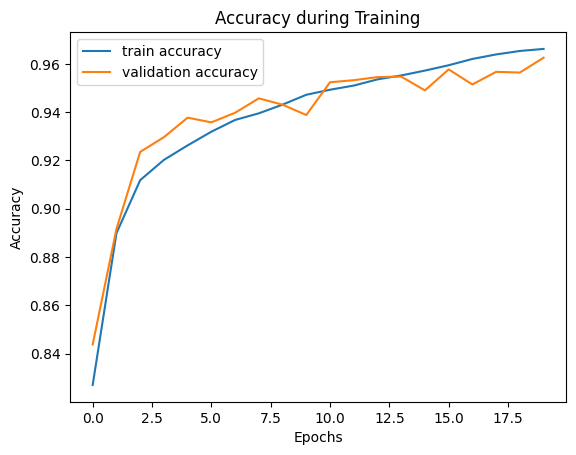

In [16]:
plt.plot(history.history['accuracy'], label="train accuracy")
plt.plot(history.history['val_accuracy'], label="validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy during Training')
plt.legend()
plt.show()

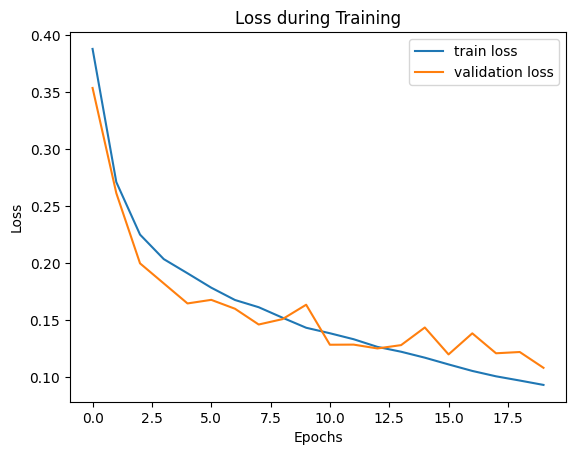

In [17]:
plt.plot(history.history['loss'], label="train loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss during Training')
plt.legend()
plt.show()

## Conclusion (15 pts)

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

It was interesting to see how the models varied in complexity influenced the train and validation accuracies as well as the training time. Each iteration was a gradual progression towards improved accuracy in mainly the validation as the training accuracy grew to an impressively high level with every iteration of model given enough epochs. The final model had an impressive boost to accuracy as it implements multiple filter sizes which I was hoping would be well tailored to this given problem statement.

In [18]:
import os

test_df = pd.DataFrame({'id': os.listdir('test')})
test_df.head()

,id
0,00cca1c4e98f0413c301f4896209412ee70de13b.tif
1,2e264957f3036f3f4093de964002108e7c5e1e08.tif
2,57fa5a0ce4bead904aff2ea7cf05f561b95d071f.tif
3,5b84115aaa8262b8ffac98c44484a637bbdd2e04.tif
4,eb68dd971f51b26317659ad155927ed420bec799.tif


In [22]:
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='test',
    x_col='id',
    y_col=None,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    steps_per_epoch=250,
    class_mode=None,
    shuffle=False
)

Found 57458 validated image filenames.


In [30]:
test_predictions = model.predict(test_generator)
test_df['label'] = (test_predictions > 0.5).astype(int)
test_df.to_csv('submission.csv', index=False)

1150/1150 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step


In [33]:
test_df['id'] = test_df['id'].str.removesuffix('.tif')
test_df.to_csv('submission.csv', index=False)
test_df.head()

,id,label
0,00cca1c4e98f0413c301f4896209412ee70de13b,0
1,2e264957f3036f3f4093de964002108e7c5e1e08,1
2,57fa5a0ce4bead904aff2ea7cf05f561b95d071f,1
3,5b84115aaa8262b8ffac98c44484a637bbdd2e04,1
4,eb68dd971f51b26317659ad155927ed420bec799,0
